<a href="https://colab.research.google.com/github/scardenol/proc_est2/blob/main/P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [607]:
# Se corre una vez al abrir una nueva sesión
# !pip install arch

In [608]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # gráficas
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pylab as plt
from arch.unitroot import ADF # Augmented Dickey Fuller, test de estacionariedad
from scipy.optimize import curve_fit # LS fit
from IPython.display import display, Math
from astropy.convolution import convolve, Box1DKernel # Convolución media móvil (LoPass-filter)

import seaborn as sns # gráficas
plt.style.use('seaborn-darkgrid') # estilo de gráficas
# plt.style.available 

import warnings
warnings.filterwarnings("ignore")

# 3. EDEL en Sentido Estricto con Nivel de Tendencia Funcional

## **Datos**

Se descargaron los datos del [Australian Government Bureau of Meteorology](http://www.bom.gov.au/climate/data/index.shtml), en particular, el histórico de [datos](http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=122&p_display_type=dailyDataFile&p_stn_num=094029&p_startYear=) de temperatura máxima diaria para la región de Hobart:


*   **Estación:** Hobart (Ellerslie Road)
*   **Número:** 94029
*   **Apertura:** 1882
*   **Estado actual:** Abierta
*   **Latitud, longitud:** 42.88°S, 147.33°E
*   **Elevación:** 51 m




In [609]:
# Urls raw del repo de github
url1 = 'https://github.com/scardenol/proc_est2/blob/main/data/IDCJAC0010_094029_1800_Data.csv?raw=true' # Max
url2 = 'https://github.com/scardenol/proc_est2/blob/main/min/IDCJAC0011_94029_1800_Data.csv?raw=true' # Min

# Leer los datos en csv
data1 = pd.read_csv(url1, delimiter=',')
data1.index = pd.to_datetime((data1['Year']*10000+data1['Month']*100+data1['Day']).apply(str), format='%Y-%m-%d')
data2 = pd.read_csv(url2, delimiter=',')
data2.index = pd.to_datetime((data2['Year']*10000+data2['Month']*100+data2['Day']).apply(str), format='%Y-%m-%d')

# Filtrar de 2017 a 2021
data1 = data1.loc['2017-01-01':'2021-01-01']
data2 = data2.loc['2017-01-01':'2021-01-01']

# Filtrar columna de temperatura máxima y mínima
data1 = data1['Maximum temperature (Degree C)']
data2 = data2['Minimum temperature (Degree C)']

# Quitar valores NA
data1 = data1.dropna()
data2 = data2.dropna()

# Promedio
data = (data1+data2)/2
data = data.dropna()
data = data.rename('Average temperature (Degree C)')

# Separación de datos en train y test
mid = len(data)//2
train = data[:mid+1]
test = data[mid+1:]

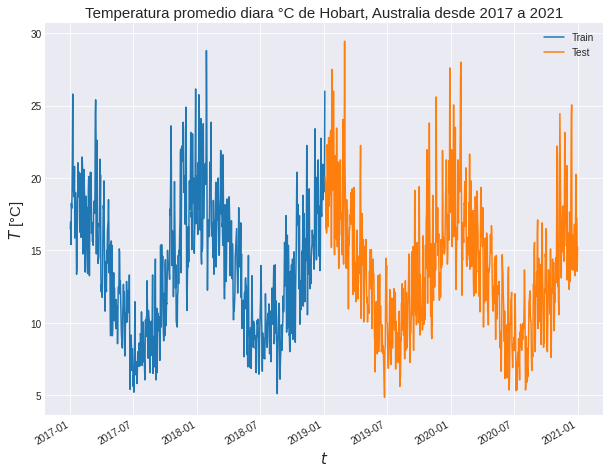

In [610]:
# Visualizar

plt.figure(figsize=(10,8))
train.plot();
test.plot();
title = r'Temperatura promedio diara °C de Hobart, Australia desde 2017 a 2021'
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$T$ [°C]', fontsize = 15);
plt.legend(['Train','Test']);

En la serie de datos se nota la presencia de una tendencia funcional periódica, sujeta de ser modelada por una función trigonométrica (seno, coseno). Esto quiere decir que se observan comportamientos de estacionariedad y periodicidad en la serie.

## Condiciones de modelación

La serie debe cumplir con ser estacionaria (tendencia funcional) y ser periódica. Por lo tanto se realiza lo siguiente:

*   **Augmented Dickey-Fuller (ADF):** test de estacionariedad. Asumiendo $\alpha = 0.05$, se tienen las hipótesis

\begin{align*}
  &\mathcal{H_0}: \quad \text{La serie no es estacionaria} \; (p>\alpha). \\
  &\mathcal{H_A}: \quad \text{La serie es estacionaria} \; (p\leq\alpha).
\end{align*}

*   **Fast Fourier Transform (FFT):** transformada rápida de Fourier. Se utiliza para validar la presencia de componentes frecuenciales en los datos, y por lo tanto, periodicidad.


In [611]:
# Test ADF (Augmented Dickey-Fuller) para estacionalidad
# https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html
adf = ADF(train, lags=7)
print(adf.summary().as_text()) # Se rechaza H0, la serie es estacionaria

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.951
P-value                         0.040
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [612]:
# FFT (Fast Fourier Transform) para periodicidad de los datos

N = len(train) # number of data points
t = np.linspace(0, 4*np.pi, N)

data = train - train.mean() # Se resta la media, pues el término 1 de fft es la media
mfft=np.fft.fft(data)
imax=np.argmax(np.absolute(mfft))
mask=np.zeros_like(mfft)
mask[[imax]]=1
mfft*=mask

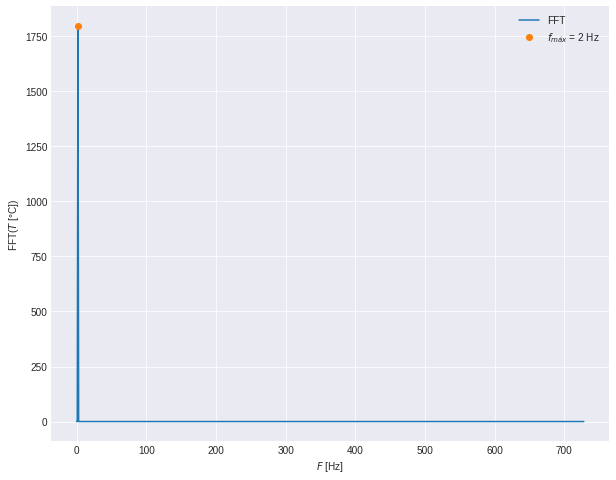

In [613]:
# Visualizar FFT

plt.figure(figsize=(10,8))

plt.plot(mfft)
fmax, fmax_idx = (np.max(mfft), np.argmax(mfft))
plt.plot(fmax_idx, fmax, 'o');
plt.xlabel('$F$ [Hz]');
plt.ylabel('FFT($T$ [°C])');
plt.legend(['FFT', '$f_{máx}$ = ' + str(fmax_idx) + ' Hz']);

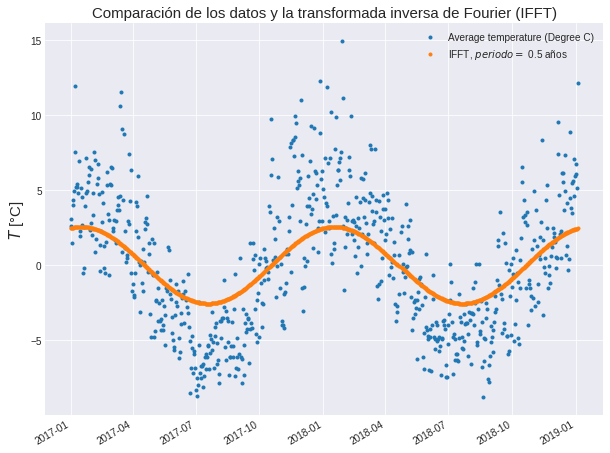

In [614]:
# Visualizar transformada inversa del resultado anterior

fdata=np.fft.ifft(mfft) # Transformada inversa de Fourier
data = pd.Series(data, train.index)
fdata = pd.Series(fdata, train.index)
Tdata = 1/fmax_idx # Periodo = 0.5 años = 6 meses

plt.figure(figsize=(10,8))

data.plot(style='.')
fdata.plot(style='.', label='IFFT, $periodo =$ ' + str(round(Tdata, 2)) + ' años')
title = 'Comparación de los datos y la transformada inversa de Fourier (IFFT)'
plt.title(title, fontsize = 15);
plt.ylabel('$T$ [°C]', fontsize = 15);
plt.legend()
plt.show()

## Estimación de parámetros

Del proceso de reversión a la media con $\gamma = 0$ y tendencia funcional se tiene

\begin{equation}
  dX_t = \alpha(\mu(t) - X_t)dt + \sigma dB_t, \quad X_0=x
\end{equation}

donde $t \in [0,T]$, $\alpha>0$, $\sigma>0$, $\mu(t) \in \mathbb{R}$ con solución
\begin{align*}
  X_t &= \mu(t) + (X_0 - \mu(t))\exp[-\alpha t] + \sigma \exp[-\alpha t] \int_0^t \exp[\alpha s] dB_s\\
\end{align*}

### a) Estimación de $\alpha, \mu(t), \sigma$

Para estimar los parámetros se utilizan los estimadores

\begin{gather*}
  \hat{\mu}(t) = m(t) + \frac{\dot{m}(t)}{\hat{\alpha}}, \quad
  \hat{\alpha} = \frac{\sum_{i=1}^T\bigg[\big(X_i - X_{i-1} - \dot{m}_{i-1} \Delta t\big)\big(m_{i-1} - X_{i-1}\big)\bigg]}{\sum_{i=1}^T\bigg[\big(m_{i-1} - X_{i-1}\big)^2 \Delta t\bigg]}, \\
  \hat{\sigma} = \sqrt{\frac{1}{T \Delta t}\sum_{i=1}^T\Bigg[X_i - X_{i-1} - \big[\hat{\alpha}\big(m_{i-1}-X_{i-1}\big) + \dot{m}_{i-1}\big]\Delta t\Bigg]^2}
\end{gather*}

Donde

\begin{gather*}
  m_i = \sum_{k=-N}^N \frac{X_{i-k}}{2N+1}, \quad \dot{m}_i = \frac{2m_{i+1}-3m_i+m_{i-1}}{\Delta t}
\end{gather*}

In [615]:
# Estimación de parámetros

p = len(train) # número de observaciones

dt = 1/p # Delta t

# mi con convolución de media móvil
# https://waterprogramming.wordpress.com/2018/09/04/implementation-of-the-moving-average-filter-using-convolution/#:~:text=A%20moving%20average%20is%20a,values%20in%20a%20moving%20window.
window = 31 # 31 por la estacionalidad dependiendo del mes del año, asumiendo 30 días + centro
mi = convolve(train,kernel=Box1DKernel(31)) # Equivalente a un filtro pasa bajas
mi = pd.Series(mi, index=train.index)

mi_dot = pd.Series(np.zeros(mi.shape), index=mi.index)

num = 0
den = 0

for i in range(1, p-1):
  mi_dot[i] = (2*mi[i+1] - 3*mi[i] + mi[i-1])/dt
  aux = mi[i-1] - train[i-1]

  num += (train[i] - train[i-1] - mi_dot[i-1]*dt)*aux
  den += (mi[i-1] - train[i-1])**2 * dt

alpha_hat = num/den

sum = 0

for i in range(1, p-1):
  aux = mi[i-1] - train[i-1]
  sum += (train[i] - train[i-1] - (alpha_hat*(aux + mi_dot[i-1])*dt))**2

sigma_hat = np.sqrt((1/(p*dt))*sum)

mu_hat = mi + mi_dot/alpha_hat

display(Math(r'\hat{\alpha} = ' + str(round(alpha_hat, 2))))
display(Math(r'\hat{\sigma} = ' + str(round(sigma_hat, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### b) Reestimación de $\alpha, \mu(t), \sigma$

Para reestimar los parámetros se utilizan los estimadores

\begin{gather*}
  \hat{\hat{\mu}} = Y_t, \quad \hat{\hat{\alpha}} = \frac{\sum_{i=1}^T\Big[\big(X_i - X_{i-1}\big)\big(\hat{\hat{\mu}}_{i-1}-X_{i-1}\big)\Big]}{\sum_{i=1}^T\Big[\big(\hat{\hat{\mu}}_{i-1} - X_{i-1}\big)^2 \Delta t\Big]}, \quad \hat{\hat{\sigma}} = \sqrt{ \frac{1}{T \Delta t} \sum_{i=1}^T \Big[X_i - X_{i-1} - \hat{\hat{\alpha}}\big(\hat{\hat{\mu}}_{i-1}-X_{i-1}\big)\Delta t\Big]^2 }
\end{gather*}

Donde $Y_t = a + b\sin(\omega t)$ con $\omega = \frac{2\pi}{T}$ y sus parámetros se estiman por mínimos cuadrados

In [616]:
omg = 2*np.pi/p

def Yt(t, a, b):
  model = a + b*np.sin(omg*t)
  return model

T = np.linspace(0, p, num = p) # Intervalo equiespaciado de tiempo

a, b = curve_fit(Yt, T, train.values)[0] # Mínimos cuadrados

mu_2hat = pd.Series(Yt(T, a, b), index=train.index)

aux = 0
num = 0
den = 0 
for i in range(1, p-1):
  aux = mu_2hat[i-1]-train[i-1]
  num += (train[i]-train[i-1]*aux)
  den += aux**2*dt

alpha_2hat = num/den

aux = 0
sum = 0
for i in range(1, p-1):
  aux = mu_2hat[i-1]-train[i-1]
  sum += (train[i]-train[i-1]-alpha_2hat*aux*dt)**2

sigma_2hat = (1/(p*dt))*sum

display(Math(r'\hat{\hat{\alpha}} = ' + str(round(alpha_2hat, 2))))
display(Math(r'\hat{\hat{\sigma}} = ' + str(round(sigma_2hat, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Simulación del modelo resultante

Despues de realizar la estimación y reestimación de los parámetros se procede a simular el proceso. Aplicando la aproximación numérica de Euler-Maruyama a la solución analítica del proceso se obtiene

\begin{align*}
  X(t) &= \hat{\hat{\mu}}(t) + (X(t-1) - \hat{\hat{\mu}}(t))\exp[-\hat{\hat{\alpha}} \Delta t] + \hat{\hat{\sigma}} \exp[-\hat{\hat{\alpha}} \Delta t] \Delta B_t
\end{align*}

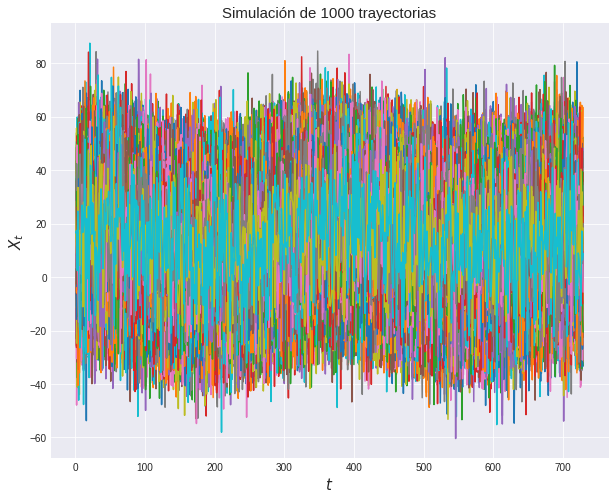

In [620]:
# Simulación

l = 1000 # número de simulaciones
p = len(train) # número de observaciones

X = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

mu = mu_hat
alpha = alpha_2hat
sigma = sigma_hat

X0 = train[0] # Valor inicial

plt.figure(figsize=(10,8))
for sim in range(l): # Ciclo de simulaciones
  X[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X[sim, t] = mu[t] + (X[sim, t-1] - mu[t])*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt
  plt.plot(p*T, X[sim]);

title = 'Simulación de ' + str(l) + r' trayectorias'
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$X_t$', fontsize = 15);

## Pronóstico

In [621]:
# Pronóstico de los datos de test

# Simulación

l = 1000 # número de simulaciones
p = len(test) # número de observaciones

X_hat = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

mu = mu_hat[:-abs(len(train)-len(test))]
mu.index = test.index
alpha = alpha_2hat
sigma = sigma_hat

X0 = train[-1] # Valor inicial

for sim in range(l): # Ciclo de simulaciones
  X_hat[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X_hat[sim, t] = mu[t] + (X_hat[sim, t-1] - mu[t])*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt

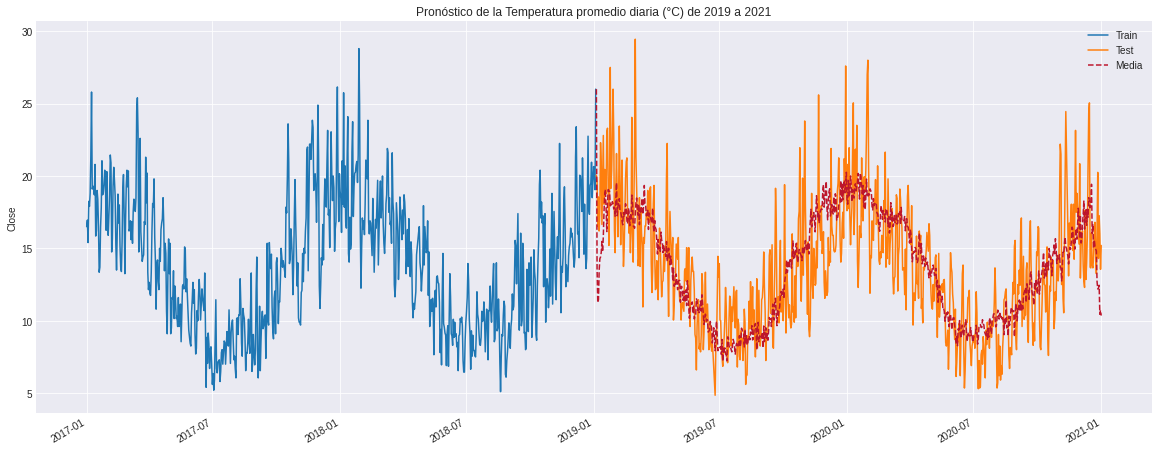

In [630]:
# Visualizar

fig1 = plt.figure(figsize=(20,8))

train.plot()
test.plot(title='Pronóstico de la Temperatura promedio diaria (°C) de 2019 a 2021');

X_hat = pd.DataFrame(X_hat)
X_hat_mean = pd.Series(X_hat.mean(axis=0).values, index=test.index)
X_hat_mean.plot(style='--', color='#BD162C');
X_hat_median = pd.Series(X_hat.quantile(q=0.5, axis=0).values, index=test.index)
# X_hat_median.plot(style='--', color='#3743ad');



# Bandas de confianzas
X_hat_hi = pd.Series(X_hat.quantile(q=0.55, axis=0).values, index=test.index)
# X_hat_hi.plot(style='--', color='black');
X_hat_lo = pd.Series(X_hat.quantile(q=0.45, axis=0).values, index=test.index)
# X_hat_lo.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Train','Test', 'Media', 'Mediana']);